In [1]:
# from datagenerator import jet_data_generator 
# from plotutils import plot_event 
import matplotlib 
import time
import os
from itertools import product
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})
import pandas as pd
from datagenerator_resonances_realistic import jet_data_generator as realistic_generator

# from datagenerator_realistic import jet_data_generator as realistic_base_generator


In [2]:
# simple_sig_2p_16part = jet_data_generator("signal",0.00005, 2, 16, True)
realistic_sig_2p_16part = realistic_generator(
    massprior="signal", 
    nprong=2, 
    nparticle=32, 
    doFixP=True, 
    resonance_data=[
        {'mass': 180.0, 'relative_ratio': 1.0, 'decay_products': 3},
        {'mass': 30.0, 'relative_ratio': 1.0, 'decay_products': 3},
        {'mass': 80.0, 'relative_ratio': 1.0, 'decay_products': 2},
        {'mass': 10.0, 'relative_ratio': 1.0, 'decay_products': 2},
    ], 
    total_resonance_prob=0.15, # Adjust total resonance probability as desired
    max_resonance_per_jet = 1
)


In [20]:
start = time.time()
realisticdata_sig_2p_16part = realistic_sig_2p_16part.generate_dataset(50,verbose = False)
end = time.time()
print(end-start)

event : 0


/n/home11/nswood/ToyJetGenerator/datagenerator_resonances_realistic.py:274: RuntimeWarning: invalid value encountered in sqrt
  return np.arctan(np.sqrt(num/den))
/n/home11/nswood/ToyJetGenerator/datagenerator_resonances_realistic.py:386: RuntimeWarning: invalid value encountered in sqrt
  zmin=np.maximum(0.2/mother.mom.p,0.5*(1-np.sqrt(1-(m/p)**2)))


event : 10


/n/holystore01/LABS/iaifi_lab/Users/nswood/mambaforge/envs/flat-samples/lib/python3.10/site-packages/pylorentz/__init__.py:447: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt(e**2 - m**2)


event : 20
event : 30
event : 40
24.38003659248352


/tmp/ipykernel_2614584/1227911886.py:148: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


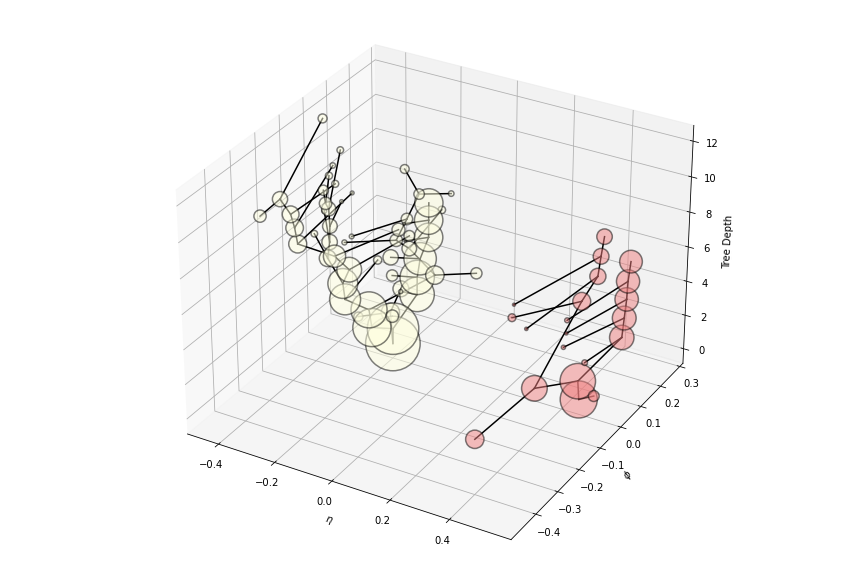

In [13]:
# %matplotlib widget  # enable interactive widget backend
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact

# Example prong-label color map
color_map = {
    -1: 'lightgray',
     0: 'lightyellow',
     1: 'lightcoral',
     2: 'lightblue',
     3: 'lightgreen',
     4: 'plum'
}

# Resonance index colors for outlines
res_index_colors = [  # High contrast with color_map
    'red',     # 3
    'blue',
    'lime',    # 4
    'green',   # 5
    'yellow',  # 6
    'purple',  # 7
    'orange',  # 8
    'brown',   # 9
    'cyan',    # 10
    'magenta', # 11
    'pink',    # 12
        # 13
    # etc.
]

def calc_tree_depth(all_parts, part_idx):
    """
    Calculates how deep a particle is in the 'shower tree':
    the number of parent links until there is no parent (-1).
    """
    depth = 0
    current_label = all_parts[part_idx].part_label
    while current_label != -1:
        parent_label = next(
            (p.part_parent_label for p in all_parts if p.part_label == current_label),
            -1
        )
        if parent_label == -1:
            break
        current_label = parent_label
        depth += 1
    return depth

def draw_3d_network(G, pos, node_colors, node_sizes, node_edgecolors, ax):
    """
    A custom routine to plot a NetworkX graph in 3D with node outlines.
    """
    # Draw edges
    for (n1, n2) in G.edges():
        x1, y1, z1 = pos[n1]
        x2, y2, z2 = pos[n2]
        ax.plot([x1, x2], [y1, y2], [z1, z2], c='black', alpha=1, linewidth = 1.5)

    # Draw nodes (as a single scatter plot)
    xs, ys, zs = [], [], []
    for node in G.nodes():
        x, y, z = pos[node]
        xs.append(x)
        ys.append(y)
        zs.append(z)

    ax.scatter(
        xs,
        ys,
        zs,
        c=node_colors,
        s=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.5,
        alpha=0.5  # Change the alpha of the edgecolor
    )

def build_shower_graph(particles):
    """
    Builds a NetworkX DiGraph for the given shower particles,
    computes node attributes, and returns (G, pos).
    pos is a dict {node_label: (x,y,z)} used for 3D drawing.
    """
    G = nx.DiGraph()
    pos = {}

    for idx, p in enumerate(particles):
        depth = calc_tree_depth(particles, idx)
        G.add_node(
            p.part_label,
            prong_label=p.prong_label,
            energy=p.mom.e,
            depth=depth,
            resonance_origin=p.resonance_origin
        )
        if p.part_parent_label > -1:
            G.add_edge(p.part_parent_label, p.part_label)

        # 3D position: (eta, phi, depth)
        pos[p.part_label] = (
            p.mom.eta.item(),
            p.mom.phi.item(),
            depth
        )

    return G, pos

def make_shower_3d_plot(shower_particles):
    """
    Given a list of shower particles, build the graph and
    plot it in a 3D figure. Returns the figure and axis.
    """
    G_shower, pos_shower = build_shower_graph(shower_particles)

    # Node face colors (by prong label)
    prong_labels = nx.get_node_attributes(G_shower, 'prong_label')
    node_colors = [color_map[prong_labels[node]] for node in G_shower.nodes]

    # Node sizes (combine energy + depth if desired)
    node_depths = nx.get_node_attributes(G_shower, 'depth')
    node_sizes = [
        (G_shower.nodes[node]['energy'] * 10)
        for node in G_shower.nodes
    ]

    # Resonance-based outline color
    resonance_edgecolors = []
    for node in G_shower.nodes:
        resonance_label = G_shower.nodes[node].get('resonance_origin', '')
        if 'Resonance' in resonance_label:
            # e.g. "Resonance_10.0_1" => ["Resonance", "10.0", "1"]
            parts = resonance_label.split('_')
            try:
                res_index = int(parts[-1])
                edge_col = res_index_colors[res_index % len(res_index_colors)]
            except ValueError:
                edge_col = 'black'
            resonance_edgecolors.append(edge_col)
        else:
            resonance_edgecolors.append('none')

    # Create the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig) 
    ax.set_title("Shower 3D View: (eta, phi, depth)")

    # Draw the network in 3D
    draw_3d_network(
        G_shower,
        pos_shower,
        node_colors=node_colors,
        node_sizes=node_sizes,
        node_edgecolors=resonance_edgecolors,
        ax=ax
    )
    

    ax.set_xlabel(f'$\eta$')
    ax.set_ylabel(f'$\phi$')
    ax.set_zlabel('Tree Depth')

    plt.show()
    

%matplotlib widget 
make_shower_3d_plot(realisticdata_sig_2p_16part[1][0])
# make_shower_3d_plot(raw_realisticdata_sig_2p_16part[4][0])

In [4]:
len(realisticdata_sig_2p_16part[1][0])

62

In [5]:
len(realisticdata_sig_2p_16part[0][0])

32

In [21]:
cur_dataset = realisticdata_sig_2p_16part[1]
n_sampels = len(cur_dataset)

sizes = [len(a) for a in cur_dataset]
print(max(sizes))

86


In [17]:
cur_particle = cur_dataset[0][0]

In [36]:


def process_dataset(cur_dataset, max_particles = 100):
    # Zero pad to max_particles or truncate if necessary
    # Particle features are [energy, pT, mass, eta, phi]
    # Particle labels are [part_label, part_parent_label, prong_label, resonance_origin]
    # part_label is the particle ID in the event
    # part_parent_label is the parent particle ID in the event
    # prong_label is the prong label to which the particle belongs
    # resonance_origin is the resonance particle that caused the decay or 'None' if generated from a regular jet shower

    feature_list = []
    label_list = []

    for particles in cur_dataset:
        # Extract features and labels for each particle
        features = []
        labels = []
        for particle in particles:
            kin_features = [particle.mom.e, particle.mom.p_t, particle.mom.m, particle.mom.eta, particle.mom.phi]
            part_labels = [particle.part_label, particle.part_parent_label, particle.prong_label, particle.resonance_origin]
            features.append(kin_features)
            labels.append(part_labels)

        # Sort by decreasing energy
        features = np.array(features)
        labels = np.array(labels)
        sorted_indices = np.argsort(-features[:, 0])
        features = features[sorted_indices]
        labels = labels[sorted_indices]

        # Zero pad to max_particles or truncate if necessary
        if len(features) < max_particles:
            padding = max_particles - len(features)
            features = np.pad(features, ((0, padding), (0, 0)), mode='constant')
            labels = np.pad(labels, ((0, padding), (0, 0)), mode='constant')
        elif len(features) > max_particles:
            features = features[:max_particles]
            labels = labels[:max_particles]

        feature_list.append(features)
        label_list.append(labels)

    return np.array(feature_list), np.array(label_list)

# Example usage
features, labels = process_dataset(realisticdata_sig_2p_16part[0], max_particles = 32)

In [33]:
features, labels = process_dataset(realisticdata_sig_2p_16part[1])

(50, 32, 5)

/tmp/ipykernel_2004504/4161487682.py:127: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


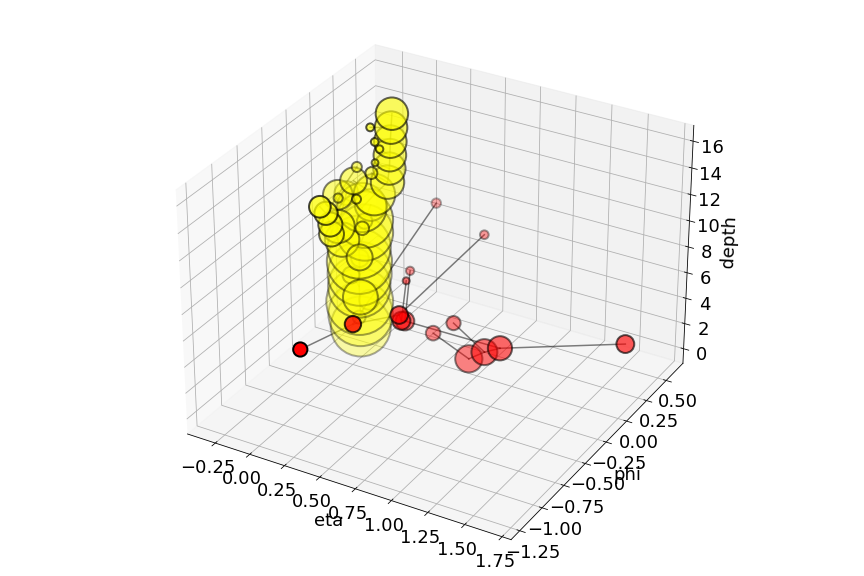

In [28]:
# %matplotlib widget  # enable interactive widget backend
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact

# Example prong-label color map
color_map = {
    -1: 'gray',
     0: 'yellow',
     1: 'red',
     2: 'blue',
     3: 'green',
     4: 'purple'
}

# Resonance index colors for outlines
res_index_colors = [
    'blue',    # 1

    'green',   # 3
    'orange',  # 4
    'purple',  # 5
    'brown',   # 6
    'cyan',    # 7
    # etc.
]

def calc_tree_depth(all_parts, part_idx):
    """
    Calculates how deep a particle is in the 'shower tree':
    the number of parent links until there is no parent (-1).
    """
    depth = 0
    current_label = all_parts[part_idx].part_label
    while current_label != -1:
        parent_label = next(
            (p.part_parent_label for p in all_parts if p.part_label == current_label),
            -1
        )
        if parent_label == -1:
            break
        current_label = parent_label
        depth += 1
    return depth

def draw_3d_network(G, pos, node_colors, node_sizes, node_edgecolors, ax):
    """
    A custom routine to plot a NetworkX graph in 3D with node outlines.
    """
    # Draw edges
    for (n1, n2) in G.edges():
        x1, y1, z1 = pos[n1]
        x2, y2, z2 = pos[n2]
        ax.plot([x1, x2], [y1, y2], [z1, z2], c='black', alpha=0.5)

    # Draw nodes (as a single scatter plot)
    xs, ys, zs = [], [], []
    for node in G.nodes():
        x, y, z = pos[node]
        xs.append(x)
        ys.append(y)
        zs.append(z)

    ax.scatter(
        xs,
        ys,
        zs,
        c=node_colors,
        s=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=2.0
    )

def build_shower_graph(particles):
    """
    Builds a NetworkX DiGraph for the given shower particles,
    computes node attributes, and returns (G, pos).
    pos is a dict {node_label: (x,y,z)} used for 3D drawing.
    """
    G = nx.DiGraph()
    pos = {}

    for idx, p in enumerate(particles):
        depth = calc_tree_depth(particles, idx)
        G.add_node(
            p.part_label,
            prong_label=p.prong_label,
            energy=p.mom.e,
            depth=depth,
        )
        if p.part_parent_label > 0:
            G.add_edge(p.part_parent_label, p.part_label)

        # 3D position: (eta, phi, depth)
        pos[p.part_label] = (
            p.mom.eta.item(),
            p.mom.phi.item(),
            depth
        )

    return G, pos

def make_shower_3d_plot(shower_particles):
    """
    Given a list of shower particles, build the graph and
    plot it in a 3D figure. Returns the figure and axis.
    """
    G_shower, pos_shower = build_shower_graph(shower_particles)

    # Node face colors (by prong label)
    prong_labels = nx.get_node_attributes(G_shower, 'prong_label')
    node_colors = [color_map[prong_labels[node]] for node in G_shower.nodes]

    # Node sizes (combine energy + depth if desired)
    node_depths = nx.get_node_attributes(G_shower, 'depth')
    node_sizes = [
        (G_shower.nodes[node]['energy'] * 10) * (1 + 0.2 * node_depths[node])
        for node in G_shower.nodes
    ]

    

    # Create the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig) 
    ax.set_title("Shower 3D View: (eta, phi, depth)")

    # Draw the network in 3D
    draw_3d_network(
        G_shower,
        pos_shower,
        node_colors=node_colors,
        node_sizes=node_sizes,
        node_edgecolors = ['black' for _ in G_shower.nodes],
        ax=ax
    )

    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_zlabel('depth')

    plt.show()
    

%matplotlib widget 
# make_shower_3d_plot(realisticdata_sig_2p_16part[1][0])
make_shower_3d_plot(raw_realisticdata_sig_2p_16part[4][0])

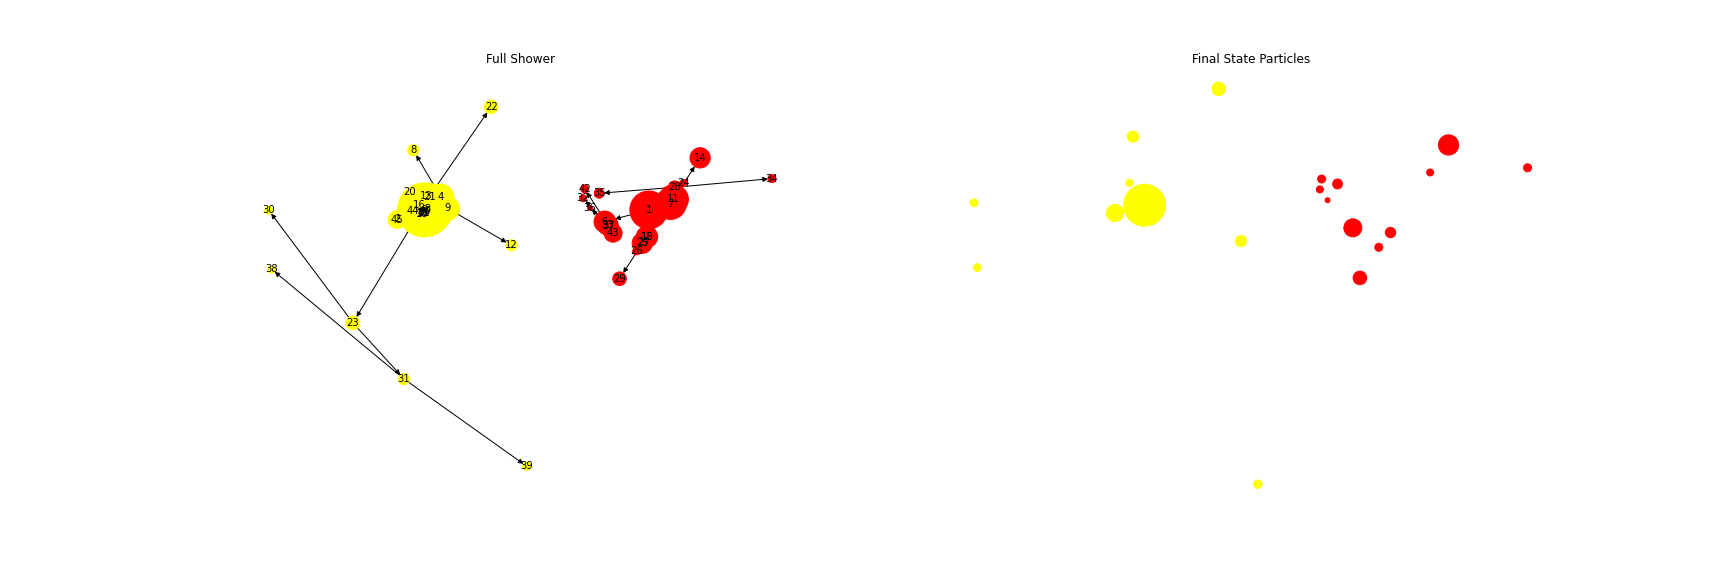

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
# Extract the particles from the dataset
color_map = {-1: 'gray', 0: 'yellow', 1: 'red', 2: 'blue', 3: 'green', 4: 'purple'}


for i in range(len(realisticdata_sig_2p_16part[1])):
    shower_particles = realisticdata_sig_2p_16part[1][i]
    final_state_particles = realisticdata_sig_2p_16part[0][i]

    # Create a directed graph for shower particles
    G_shower = nx.DiGraph()
    for particle in shower_particles:
        
        G_shower.add_node(particle.part_label, prong_label=particle.prong_label, energy=particle.mom.e)
        if particle.part_parent_label > 0:
            G_shower.add_edge(particle.part_parent_label, particle.part_label)
    
    # Get the prong labels for coloring
    prong_labels_shower = nx.get_node_attributes(G_shower, 'prong_label')
    node_colors_shower = [color_map[prong_labels_shower[node]] for node in G_shower.nodes]
    node_sizes_shower = [G_shower.nodes[node]['energy'] * 10 for node in G_shower.nodes]
    pos_shower = {particle.part_label: (particle.mom.eta.item(), particle.mom.phi.item()) for particle in shower_particles}

    # Create a directed graph for final state particles
    G_final = nx.DiGraph()
    for particle in final_state_particles:
        G_final.add_node(particle.part_label, prong_label=particle.prong_label, energy=particle.mom.e)

    # Get the prong labels for coloring
    prong_labels_final = nx.get_node_attributes(G_final, 'prong_label')
    node_colors_final = [color_map[prong_labels_final[node]] for node in G_final.nodes]
    node_sizes_final = [G_final.nodes[node]['energy'] * 10 for node in G_final.nodes]
    pos_final = {particle.part_label: (particle.mom.eta.item(), particle.mom.phi.item()) for particle in final_state_particles}

    # Draw the graphs side by side
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))

    # Plot shower particles
    axes[0].set_title('Full Shower')
    nx.draw(G_shower, pos_shower, with_labels=True, node_color=node_colors_shower, node_size=node_sizes_shower, font_size=10, font_color='black', ax=axes[0])

    # Plot final state particles
    axes[1].set_title('Final State Particles')
    nx.draw(G_final, pos_final, with_labels=False, node_color=node_colors_final, node_size=node_sizes_final, font_size=10, font_color='black', ax=axes[1])

    plt.show()


In [5]:
first_part = realistic_sig_2p_16part.draw_first_particle()

In [ ]:
randomdraw_phi = np.random.uniform(0,2*np.pi)

z,theta,m1,m2 = realistic_sig_2p_16part.randz(mother = first_part, iPhi = randomdraw_phi)
resonance_mass = 30

d1 = np.abs(m1-resonance_mass)
d2 = np.abs(m2-resonance_mass)
if d1 < d2:
    print("Closest mass: ", m1)
    mass_shift = resonance_mass - m1
    print('Mass shift: ', mass_shift)
    m1 = resonance_mass
    m2 = m2 - mass_shift
    print('Adjusted m2: ', m2)
else:
    print("Closest mass: ", m2)
    mass_shift = resonance_mass - m2
    print('Mass shift: ', mass_shift)
    m2 = resonance_mass
    m1 = m1 - mass_shift
    print('Adjusted m1: ', m1)

resonance_mom, quark_mom = realistic_sig_2p_16part.dau2(first_part,resonance_mass,theta,z,randomdraw_phi)
print(resonance_mom.m, quark_mom.m)
    

In [91]:
d1,d2,z,theta = realistic_sig_2p_16part.hardsplit(first_part,1)

In [ ]:
d1.mom.m

In [ ]:
d2.mom.m

In [7]:
four_vec= [109.736, 88.8394, 3.75664e-15, 50.3493]
m = np.sqrt(four_vec[0]**2 - four_vec[1]**2 - four_vec[2]**2 - four_vec[3]**2)
p = np.sqrt(four_vec[1]**2 + four_vec[2]**2 + four_vec[3]**2)

In [8]:
def theta_func(z,m,m1,m2,p):
    val0=(1./(4.*p**2))*(m**4-2*(m**2)*(m1**2+m2**2)+(m1**2-m2**2)**2)
    val1=z*(m1**2-m2**2)
    val2=m1**2
    val3=z*(1-z)*m**2
    num=(val0+val1-val2+val3)
    den=(p**2+m**2)
    return np.arctan(np.sqrt(num/den))

In [ ]:
m2_range = np.linspace(1, 50, 100)
z_raneg = np.linspace(0.3, 1, 100)
m1 = 30
y = theta_func(0.1,m,m1,m2_range,p)
Z, M2 = np.meshgrid(z_raneg, m2_range)
theta_values = np.vectorize(theta_func)(Z, m, m1, M2, p)

plt.contourf(M2, Z, theta_values, levels=50, cmap='viridis')
plt.colorbar(label='theta')
plt.xlabel("m2")
plt.ylabel("z")
plt.title("2D Color Plot of theta")
plt.show()

In [4]:
df = pd.read_csv('processed_gromov_toy_data.csv')

In [ ]:
import matplotlib.pyplot as plt

# Get unique values for n_parts and n_prong
unique_n_parts = df['n_parts'].unique()
unique_n_prongs = df['n_prong'].unique()

# Create subplots
fig, axes = plt.subplots(len(unique_n_parts), len(unique_n_prongs), figsize=(5 * len(unique_n_prongs), 5 * len(unique_n_parts)), sharex=True, sharey=True)

# Plot histograms
for i, n_parts in enumerate(unique_n_parts):
    for j, n_prong in enumerate(unique_n_prongs):
        ax = axes[i, j]
        subset = df[(df['n_parts'] == n_parts) & (df['n_prong'] == n_prong)]
        ax.hist(subset['delta'], bins=50, density=True, alpha=0.6, label=f'n_parts={n_parts}, n_prong={n_prong}')
        ax.set_title(f'n_parts={n_parts}, n_prong={n_prong}')
        ax.set_xlabel('delta')
        ax.set_ylabel('Density')
        # ax.legend()

        

plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('per_particle_gromov_toy_data.csv')

In [114]:
df_shower = df[df['data_type'] == 'shower']
df_fs = df[df['data_type'] == 'final_state']


In [ ]:
grouped = df_fs.groupby(['num_parts', 'num_prong'])

# Define the bins
rel_bins = np.linspace(0, 2, 50)

bins = np.linspace(0, 0.1, 50)


for combo in product(df_fs['num_parts'].unique(), df_fs['num_prong'].unique()):
    plt.figure()
    for k in df_fs['k'].unique():
        try:
            subset = grouped.get_group(combo)
            k_grouped = subset.groupby(['k']).get_group(k)
            plt.hist(k_grouped['rel_delta'], bins=rel_bins, label=f'K = {k}', histtype='step',density = 'True')
            plt.title(f'n_parts={combo[0]}, n_prong={combo[1]}')
            plt.legend()
            plt.xlabel('rel_delta')
            plt.ylabel('Density')
        except KeyError:
            # This combination doesn't exist in the data
            pass
    plt.show()
    plt.figure()
    for k in df_fs['k'].unique():
        try:
            subset = grouped.get_group(combo)
            k_grouped = subset.groupby(['k']).get_group(k)
            plt.hist(k_grouped['delta'], bins=bins, label=f'K = {k}', histtype='step',density = 'True')
            plt.title(f'n_parts={combo[0]}, n_prong={combo[1]}')
            plt.legend()
            plt.xlabel('delta')
            plt.xscale('log')
            plt.ylabel('Density')
        except KeyError:
            # This combination doesn't exist in the data
            pass
    plt.show()


In [ ]:
realisticdata_sig_2p_16part[4][0].shape

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Extract the particles from the dataset
color_map = {-1: 'gray', 0: 'yellow', 1: 'red', 2: 'blue', 3: 'green', 4: 'purple'}


for i in range(5):
    shower_particles = realisticdata_sig_2p_16part[4][i]
    final_state_particles = realisticdata_sig_2p_16part[3][i]

    # Create a directed graph for shower particles
    G_shower = nx.DiGraph()
    for particle in shower_particles:
        G_shower.add_node(particle.part_label, prong_label=particle.prong_label, energy=particle.mom.e)
        if particle.part_parent_label > 0:
            G_shower.add_edge(particle.part_parent_label, particle.part_label)

    # Get the prong labels for coloring
    prong_labels_shower = nx.get_node_attributes(G_shower, 'prong_label')
    node_colors_shower = [color_map[prong_labels_shower[node]] for node in G_shower.nodes]
    node_sizes_shower = [G_shower.nodes[node]['energy'] * 10 for node in G_shower.nodes]
    pos_shower = {particle.part_label: (particle.mom.eta.item(), particle.mom.phi.item()) for particle in shower_particles}

    # Create a directed graph for final state particles
    G_final = nx.DiGraph()
    for particle in final_state_particles:
        G_final.add_node(particle.part_label, prong_label=particle.prong_label, energy=particle.mom.e)

    # Get the prong labels for coloring
    prong_labels_final = nx.get_node_attributes(G_final, 'prong_label')
    node_colors_final = [color_map[prong_labels_final[node]] for node in G_final.nodes]
    node_sizes_final = [G_final.nodes[node]['energy'] * 10 for node in G_final.nodes]
    pos_final = {particle.part_label: (particle.mom.eta.item(), particle.mom.phi.item()) for particle in final_state_particles}

    # Draw the graphs side by side
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))

    # Plot shower particles
    axes[0].set_title('Full Shower')
    nx.draw(G_shower, pos_shower, with_labels=False, node_color=node_colors_shower, node_size=node_sizes_shower, font_size=10, font_color='black', ax=axes[0])

    # Plot final state particles
    axes[1].set_title('Final State Particles')
    nx.draw(G_final, pos_final, with_labels=False, node_color=node_colors_final, node_size=node_sizes_final, font_size=10, font_color='black', ax=axes[1])

    plt.show()


In [10]:
import torch

In [18]:
def delta_hyp(dismat):
    p = 0
    row = dismat[p, :][None, :]
    col = dismat[:, p][:, None]
    XY_p = 0.5 * (row + col - dismat)
    maxmin = torch.minimum(XY_p[:, :, None], XY_p[None, :, :]).max(1).values
    return (maxmin - XY_p).max()

def find_neighbors_knn(four_momentum_tensor, dists, index, k=5):
    # Randomly select a point
    num_points = four_momentum_tensor.shape[0]
    selected_point = four_momentum_tensor[index]
    
    # Find the indices of the k-nearest neighbors
    neighbors_indices = torch.topk(dists[index], k, largest=False).indices

    neighbors = four_momentum_tensor[neighbors_indices]

    return selected_point, neighbors, neighbors_indices

In [19]:
# final_state_particles
all_k = [5,8,12]
e_eta_phi = []
results = []
for part in final_state_particles:
    mom = part.mom
    e_eta_phi.append([mom.e, mom.eta.item(), mom.phi.item()])

e_eta_phi = np.array(e_eta_phi)
four_momentum_tensor = torch.tensor(e_eta_phi)

# Extract energy, eta, phi
energies = four_momentum_tensor[:, 0]
normalized_energies = energies / energies.sum()
energies = normalized_energies
etas = four_momentum_tensor[:, 1]
phis = four_momentum_tensor[:, 2]

# Compute pairwise energy differences
energy_diffs = torch.abs(energies[:, None] - energies[None, :])
delta_eta = etas[:, None] - etas[None, :]
delta_phi = phis[:, None] - phis[None, :]
delta_phi = torch.remainder(delta_phi + np.pi, 2 * np.pi) - np.pi
delta_R = torch.sqrt(delta_eta ** 2 + delta_phi ** 2)

R = 1
dists = (energy_diffs * delta_R) / R
delta = delta_hyp(dists)
for j in range(len(four_momentum_tensor)):
    n_parts = len(four_momentum_tensor)

    for k in all_k:
        # print(k)
        selected_point, neighbors, neighbors_indices = find_neighbors_knn(four_momentum_tensor, dists, index=j, k=k)

        # Extract the submatrix for the neighbors
        neighbors_dists = dists[neighbors_indices][:, neighbors_indices]

        delta = delta_hyp(neighbors_dists)
        diam = neighbors_dists.max()
        rel_delta = (2 * delta) / diam

        # Calculate c based on relative delta mean
        c = (0.144 / rel_delta) ** 2

        # Save the results
        results.append({
            'selected_point_energy': selected_point[0].item(),
            'selected_point_eta': selected_point[1].item(),
            'selected_point_phi': selected_point[2].item(),
            'num_parts': n_parts,
            'k': k,
            'delta': delta.item(),
            'rel_delta': rel_delta.item(),
            'c': c.item(),
        })




In [22]:
import pandas as pd

In [23]:
df = pd.DataFrame(results)

In [ ]:
df.head()

In [ ]:
df[df['k'] == 5].plot.scatter(x='selected_point_energy', y='delta')



In [30]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    fig.savefig(f'figures/{name}.png')

    
def plot_two_event(pfcand1, pfcand2,augmentation_name):
    # Extract pt, eta, and phi from both events
    pt1 = pfcand1[:,0]
    eta1 = pfcand1[:,1]
    phi1 = pfcand1[:,2]

    pt2 = pfcand2[:,0]
    eta2 = pfcand2[:,1]
    phi2 = pfcand2[:,2]

    # Create subplots with two axes side by side
    fig, axes = plt.subplots(2,1, figsize=(6, 10))

    # Plot the first event
    axes[0].scatter(eta1, phi1, s=pt1*10, alpha=0.2)
    axes[0].set_xlabel('eta')
    axes[0].set_ylabel('phi')
    axes[0].set_xlim([-1, 1])
    axes[0].set_ylim([-1, 1])
    axes[0].set_title(f'Original Jet')

    # Plot the second event
    axes[1].scatter(eta2, phi2, s=pt2*10, alpha=0.2)
    axes[1].set_xlabel('eta')
    axes[1].set_ylabel('phi')
    axes[1].set_xlim([-1, 1])
    axes[1].set_ylim([-1, 1])
    axes[1].set_title(f'{augmentation_name}')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
#     fig.savefig(f'figures/{name}.png')

In [9]:
import copy
from pylorentz import Momentum4
 
def soft_splitting_augmentation(gen_function, particles_list,n_splits_mid, n_splits_std):
    particles = copy.deepcopy(particles_list)
    n_splittings = int(np.random.normal(loc=n_splits_mid, scale=n_splits_std))
#     print(f'Splitting {n_splittings} particles with soft splitting')
    for _ in range(n_splittings):
        dau1, dau2, z, theta = gen_function.softsplit(particles[0])
        particles.pop(0)
        gen_function.reverse_insort(particles, dau1)
        gen_function.reverse_insort(particles, dau2)
        
    return particles

# new function
# randomly selects root
# merges it with lowest particle energy weighted distance 
def soft_merging_augmentation(gen_function, particles_list,n_merges_mid, n_merges_std):
    particles = copy.deepcopy(particles_list)
    all_e = []
    all_phi = []
    all_eta = []
    for p in particles:
        mom = p.mom
        all_e.append(mom[0])
        all_phi.append(mom.phi)
        all_eta.append(mom.eta)
        
    all_e = np.array(all_e)
    all_phi = np.array(all_phi)
    all_eta = np.array(all_eta)

    phi_diff = (all_phi[:, np.newaxis] - all_phi[np.newaxis, :]).squeeze()
    eta_diff = (all_eta[:, np.newaxis] - all_eta[np.newaxis, :]).squeeze()

    pairwise_matrix = ((phi_diff**2 + eta_diff**2) * (all_e[:, np.newaxis] + all_e[np.newaxis, :]) / 2) + 1000*np.eye(len(particles))
    print(pairwise_matrix.shape)
    n_merges = int(np.random.normal(loc=n_merges_mid, scale=n_merges_std))
    for _ in range(n_merges):
        root = int(np.abs(np.random.normal(loc=0, scale=2)))
        dau2_id = np.argmin(pairwise_matrix[-root])
        
        mother = gen_function.softcombine(particles[-root],particles[dau2_id])
        if root > dau2_id:
            particles.pop(root)
            particles.pop(dau2_id)
        else:
            particles.pop(dau2_id)
            particles.pop(root)
        # need to update pairwise matrix to remove particles dropped and add info for new particles 
#         gen_function.reverse_insort(particles, mother)
        mother_index = gen_function.reverse_insort(particles, mother)
        # Update the pairwise matrix:
        # 1. Remove the rows/columns of the merged particles
        all_e = []
        all_phi = []
        all_eta = []
        for p in particles:
            mom = p.mom
            all_e.append(mom[0])
            all_phi.append(mom.phi)
            all_eta.append(mom.eta)

        all_e = np.array(all_e)
        all_phi = np.array(all_phi)
        all_eta = np.array(all_eta)

        phi_diff = (all_phi[:, np.newaxis] - all_phi[np.newaxis, :]).squeeze()
        eta_diff = (all_eta[:, np.newaxis] - all_eta[np.newaxis, :]).squeeze()

        pairwise_matrix = ((phi_diff**2 + eta_diff**2) * (all_e[:, np.newaxis] + all_e[np.newaxis, :]) / 2) + 1000*np.eye(len(particles))

        
    return particles


def rotation_augmentation(gen_function, particles_list):
    particles = copy.deepcopy(particles_list)
    n_particles = len(particles_list)
    theta = np.random.uniform(low=0,high = np.pi)
#     print(f'Rotating {n_particles} particles')
    for i in range(n_particles):
        rotated_particle_mom = gen_function.rotatePhi(particles[i].mom,theta)
        particles[i].mom = rotated_particle_mom
        
    return particles

def rotation_matrix_x(theta):
    # Create an identity matrix
    rotation_matrix = np.eye(4)
    
    # Set the rotation part for the y-z plane
    rotation_matrix[1, 1] = np.cos(theta)
    rotation_matrix[1, 2] = -np.sin(theta)
    rotation_matrix[2, 1] = np.sin(theta)
    rotation_matrix[2, 2] = np.cos(theta)
    
    return rotation_matrix



def Lorentz_xy_rotation_augmentation(gen_function, particles_list):
    particles = copy.deepcopy(particles_list)
    n_particles = len(particles_list)
    theta = np.random.uniform(low=0,high = 0.5)
    M = rotation_matrix_x(theta)
    print(f'Rotating {n_particles} particles')
    for i in range(n_particles):
        mom = particles[i].mom
        mom_vec = np.array([mom.p_t,mom.p_x,mom.p_y,mom.p_z])
        rotated_mom = M@mom_vec
        new_mom = Momentum4(rotated_mom[0],rotated_mom[1],rotated_mom[2],rotated_mom[3])
        particles[i].mom = new_mom
        
    return particles

def boost_matrix_z(eta):
    # Create an identity matrix
    rotation_matrix = np.eye(4)
    
    # Set the rotation part for the y-z plane
    rotation_matrix[0, 0] = np.cosh(eta)
    rotation_matrix[1, 3] = np.sinh(eta)
    rotation_matrix[0, 3] = np.sinh(eta)
    rotation_matrix[3, 3] = np.cosh(eta)
    
    return rotation_matrix
    
def Lorentz_z_boost_augmentation(gen_function, particles_list):
    particles = copy.deepcopy(particles_list)
    n_particles = len(particles_list)
    eta = np.random.normal(loc=0, scale=0.25)
    M = boost_matrix_z(eta)
    print(f'Rotating {n_particles} particles')
    for i in range(n_particles):
        mom = particles[i].mom
        mom_vec = np.array([mom.p_t,mom.p_x,mom.p_y,mom.p_z])
        boosted_mom = M@mom_vec
        new_mom = Momentum4(boosted_mom[0],boosted_mom[1],boosted_mom[2],boosted_mom[3])
        particles[i].mom = new_mom
        
    return particles  

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a random test dataframe with some categorical 'Prongs' and numerical values
np.random.seed(42)  # For reproducibility
n_samples = 100
df = pd.DataFrame({
    'PCA1': np.random.randn(n_samples),
    'PCA2': np.random.randn(n_samples),
    'PCA3': np.random.randn(n_samples),
    'Prongs': np.random.choice(['1 Prong', '2 Prong', '3 Prong', '4 Prong'], n_samples)
})



In [ ]:
dir(ax._legend)

In [ ]:
# Create the pairplot and keep the default legend
ax = sns.pairplot(df, hue='Prongs', kind="scatter", palette='tab10', diag_kind='kde')
ax._legend.remove()

# Move the legend using the underlying Matplotlib API
ax.add_legend(title="Prongs", bbox_to_anchor=(0.5, -0.05), loc='center', ncol=4, frameon=False)
# Adjust the font size for the legend
ax.map_lower(sns.kdeplot, levels=4, color=".2")
plt.setp(ax._legend.get_texts(), fontsize='30')
plt.setp(ax._legend.get_title(), fontsize='30')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [ ]:
import h5py
with h5py.File('test_data/jet_2_0.h5', 'r') as f:
    # List all datasets in the file
    print("Datasets in the file:", list(f.keys()))
    
    # Load the datasets
    data = f['data'][:]
    aug_data = f['aug_data'][:]

index = np.random.randint(0,1000)    
plot_two_event(data[index].reshape(-1,3),aug_data[index].reshape(-1,3),'Augmentated Jet')

In [ ]:
import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_z_boost_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Z-boost Augmentation')

In [ ]:

import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_xy_rotation_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'X-Y Rotation Augmentation')

In [ ]:
import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_z_boost_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Z-boost Augmentation')

In [ ]:
import numpy as np
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = soft_merging_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),5,2)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Merging Augmentation')

In [24]:
def apply_augmentation(gen_function,data,aug_fn):
    
    augmented_jet = aug_fn(gen_function,list(data),5,2)
    augmented_arr = []
    for j in range(len(augmented_jet)):
        augmented_arr.append(augmented_jet[j].mom.p_t)
        augmented_arr.append(augmented_jet[j].mom.eta)
        augmented_arr.append(augmented_jet[j].mom.phi)
    augmented_arr = np.array(augmented_arr)
    return augmented_arr


In [22]:
import random
def gen_data_pairs(out_dir, n_prongs, n_samples,n_parts, functions):
    gen_function = realistic_generator("signal",n_prongs, n_parts, True)
    data_arr,_,_,data_particles = gen_function.generate_dataset(n_samples)
    aug_arr = []
    for d in data_particles:
        cur_fun = random.choice(functions)
        cur_aug_arr = apply_augmentation(gen_function, d,cur_fun)
        aug_arr.append(cur_aug_arr)
    return data_arr, aug_arr
        
    
    

In [ ]:
data, aug_data = gen_data_pairs('',
               1,
               10,
               24,
#                [soft_splitting_augmentation,soft_merging_augmentation]
               [soft_merging_augmentation]
               )


In [ ]:
plot_two_event(data[0].reshape(-1,3),aug_data[0].reshape(-1,3),'Augmentation Pair')

In [ ]:
n_parts = np. 
realisticdata_sig_2p_16part[3].shape

In [ ]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = Lorentz_xy_rotation_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]))
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Rotation Augmentation')

In [ ]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet = soft_splitting_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),10,2)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Splitting Augmentation')

In [ ]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet1 = soft_splitting_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),10,2)
augmented_jet = rotation_augmentation(realistic_sig_2p_16part,augmented_jet1)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Splitting + Rotation \n Augmentation')

In [ ]:
original_jet = realisticdata_sig_2p_16part[0][0].reshape(-1,3)

augmented_jet1 = soft_merging_augmentation(realistic_sig_2p_16part,list(realisticdata_sig_2p_16part[3][0]),10,2)
augmented_jet = rotation_augmentation(realistic_sig_2p_16part,augmented_jet1)
augmented_arr = []
for j in range(len(augmented_jet)):
    augmented_arr.append(augmented_jet[j].mom.p_t)
    augmented_arr.append(augmented_jet[j].mom.eta)
    augmented_arr.append(augmented_jet[j].mom.phi)
augmented_arr = np.array(augmented_arr)

plot_two_event(original_jet,augmented_arr.reshape(-1,3),'Soft Merging + Rotation \n Augmentation')

In [ ]:
plot_event(original_jet,arr.reshape(-1,3))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realisticdata_sig_2p_16part[1][:,0],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realisticdata_sig_2p_16part[1][:,1],alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
#fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing_Log.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(realistic_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(realistic_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.png')
fig.savefig('./figures/paper/realistic_toyjet_momentum_sharing.pdf')

In [22]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g, simple}$')
ax.set_ylabel('Density')
ax.text(0.05, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Zg.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.thetahard,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.thetasoft,alpha=0.4,bins=np.arange(0,1.8,0.02),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$\theta_{branch, simple}$')
ax.set_ylabel('Density')
ax.text(0.55, 0.73, 'Simple Toy Jet', transform=ax.transAxes)

fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.png')
fig.savefig('./figures/paper_JHEP/SimpleToyJet_Theta.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
ax.set_yscale('log')

fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.png')
fig.savefig('./figures/paper/simple_toyjet_momentum_sharing_Log.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(simple_sig_2p_16part.zhard,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Hard Splitting")
ax.hist(simple_sig_2p_16part.zsoft,alpha=0.4,bins=np.linspace(0,0.5,51),density=True,label="Soft Splitting")
ax.legend()
ax.set_xlabel(r'$z_{g}$')
ax.set_ylabel('Density')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.png')
#fig.savefig('./figures/paper/simple_toyjet_momentum_sharing.pdf')

In [ ]:
data_sig_2p_8part.shape

In [48]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    fig.savefig(f'figures/{name}.png')
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [50]:
sig_3p_8part = jet_data_generator("signal",0.00005, 3, 8, True)

In [51]:
data_sig_3p_8part = sig_3p_8part.generate_dataset(100)

In [ ]:
plot_event(data_sig_3p_8part[99].reshape(-1,3), "top_3p_8part")

In [ ]:
start = time.time()
data_sig_2p_2part = sig_2p_2part.generate_dataset(100)
end = time.time()
print(end-start)

In [ ]:
plot_event(data_sig_2p_2part[5].reshape(-1,3), "sig_2p_2part")

In [ ]:
sig_2p_3part = jet_data_generator("signal",0.00005, 2, 3)

In [ ]:
data_sig_2p_3part = sig_2p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_2p_3part[5].reshape(-1,3), "sig_2p_3part")

In [ ]:
sig_3p_3part = jet_data_generator("signal",0.00005, 3, 3)

In [ ]:
data_sig_3p_3part = sig_3p_3part.generate_dataset(100)


In [ ]:
plot_event(data_sig_3p_3part[1].reshape(-1,3), "sig_3p_3part")

## 